# Topic Estimation Steps:


1. Text preprocessing and tokenization

2. Train topic estimation model
    - Make document-term matrix
        - input: tokens 
        - tool: CountVectorizer
    - Make topic distribution matrix
        - input:
            i) document-term matrix -> term-document matrix -> corpus
            ii) dictionary (from gensim, Not pandas dict)
        - tool: Latent Dirichlet Allocation
    - Evaluate coherence
3. Visualization model
    - tool: pyLDAvis
    - also, each piece of text is expressed in terms of a list of topics, and the probability for each topic


# Import libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import re

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim import corpora
from gensim import matutils, models
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim_models


In [2]:
# in order to use NLTK's lemmatizer, need to download library

import nltk
# nltk.download('wordnet')

# to see where it is downloaded to
print(nltk.find('corpora/wordnet.zip'))

/Users/carmen/nltk_data/corpora/wordnet.zip


# Text to be grouped into different topics

In [3]:
pd.set_option('display.max_colwidth', None)

In [10]:
df = pd.read_excel('../data/drug_names_kaggle_TASK.xlsx',
                  header = 1,
                  usecols = [1])

In [11]:
df.head(2)

,Introduction
0,Acnesol Gel is an antibiotic that fights bacte...
1,Ambrodil Syrup is used for treating various re...


# Topic Estimation

## 1. Text preprocessing and tokenization

In [6]:
def tokenize(text):
    
    list_str_exclude = ['mg', 'ml', 'gm', 'iu', 'mcg']
    # need to add words to this list manually
    
    tokenizer = RegexpTokenizer(r'\w+')
    text = text.lower()
#     print(text)
    tokenized_text = tokenizer.tokenize(text)
#     print(tokenized_text)

    # Remove numbers, but not words that contain numbers.
    tokenized_text = [token for token in tokenized_text if not token.isnumeric()]

    # Remove words that are only one character.
    tokenized_text = [token for token in tokenized_text if len(token) > 1]
    
    # Remove words that are dosage
    tokenized_text = [token for token in tokenized_text if not any(unimportant in token for unimportant in list_str_exclude)]
    
    return tokenized_text

In [7]:
def lemmatize_tokens(tokens):
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [8]:
df['tokens'] = df['Introduction'].apply(lambda x: lemmatize_tokens(tokenize(x)))

In [9]:
df.head(2)

,Introduction,tokens
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, is, an, antibiotic, that, fight, bacteria, it, is, used, to, treat, acne, which, appears, a, spot, or, pimple, on, your, face, chest, or, back, this, medicine, work, by, attacking, the, bacteria, that, cause, these, pimple, acnesol, gel, is, only, meant, for, external, use, and, should, be, used, a, advised, by, your, doctor, you, should, normally, wash, and, dry, the, affected, area, before, applying, thin, layer, of, the, medicine, it, should, not, be, applied, to, broken, or, damaged, skin, avoid, any, contact, with, your, eye, nose, or, mouth, rinse, it, off, with, water, if, you, accidentally, get, it, in, ...]"
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, is, used, for, treating, various, respiratory, tract, disorder, associated, with, excessive, mucus, it, work, by, thinning, and, loosens, mucus, in, the, nose, windpipe, and, lung, and, make, it, easier, to, cough, out, ambrodil, syrup, should, be, taken, with, food, for, better, result, it, is, suggested, to, take, it, at, the, same, time, every, day, the, dose, and, how, often, you, take, it, depends, on, what, you, are, taking, it, for, your, doctor, will, decide, how, much, you, need, to, improve, your, symptom, it, is, advised, not, to, use, it, for, more, than, day, without, doctor, consultation, the, most, ...]"


## 2. Train topic estimation model

In [10]:
def create_corpus_dictonary(text_data, max_term_freq, min_term_count):

    def identity_tokenizer(text):
        return text
    
    # create document-term matrix
    count_vectorizer = CountVectorizer(tokenizer = identity_tokenizer,
                                      lowercase = False,
                                      max_df = max_term_freq, # ignoring terms that have a document frequency > x% of the number of document (by percentage)
                                      min_df = min_term_count) # ignoring terms that have a document frequency < x (count) 

    count_matrix = count_vectorizer.fit_transform(text_data)
    print('count_matrix.shape: ', count_matrix.shape)
    
    # create dictionary of index: term
    dictionary = count_vectorizer.get_feature_names_out()
    print('length of dictionary: ', len(dictionary))
    id2word = {v: k for v, k in enumerate(dictionary)}    
    # for coherence evaluation, create dictionary of term: index
    word2id = dict((k, v) for k, v in count_vectorizer.vocabulary_.items())

    d = corpora.Dictionary()
    d.id2token = id2word
    d.token2id = word2id

    
    # create term-document matrix
    count_matrix_T = count_matrix.transpose()
    # convert from sparse to proper format for LDA
    corpus = matutils.Sparse2Corpus(count_matrix_T)
    
    return corpus, d, id2word, word2id


In [11]:
def train_model_get_coherence_score(corpus, id2word, topic_count, word2id):
    
    passes = 10
    iterations = 50 # 50 is the default
    
    lda = models.LdaModel(corpus = corpus,
                          id2word = id2word,
                          num_topics = topic_count,
                          passes = passes,
                          iterations = iterations)
    
    # evaluation coherence
    coherence_model_lda = CoherenceModel(model = lda, 
                                         corpus = corpus, 
                                         dictionary = word2id, 
                                         coherence = 'u_mass'
                                        )
    coherence_lda = coherence_model_lda.get_coherence()
    
    return lda, coherence_lda
    

### fix max_term_freq and min_term_freq, vary topic_count

In [12]:
starttime = time.time()

max_term_freq = 0.7
min_term_count = 1

Corpus, D, Id2word, Word2id = create_corpus_dictonary(df['tokens'], max_term_freq, min_term_count)
print('max_term_freq = {}, min_term_count = {}'.format(max_term_freq, min_term_count))

elapsedtime = time.time() - starttime
print('time taken to calculate: {}'.format(elapsedtime))

count_matrix.shape:  (1000, 2710)
length of dictionary:  2710
max_term_freq = 0.7, min_term_count = 1
time taken to calculate: 0.08605408668518066


/Users/carmen/anaconda3/envs/streamlit_conda391/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
dict_coherence_score_topic_count = {}
for i in range(3, 10):
    Lda, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, i, Word2id)
    dict_coherence_score_topic_count[i] = Coherence_score

In [14]:
dict_coherence_score_topic_count = dict(sorted(dict_coherence_score_topic_count.items()))

Text(0.5, 1.0, 'Max_term_freq = 0.7, min_term_count = 1')

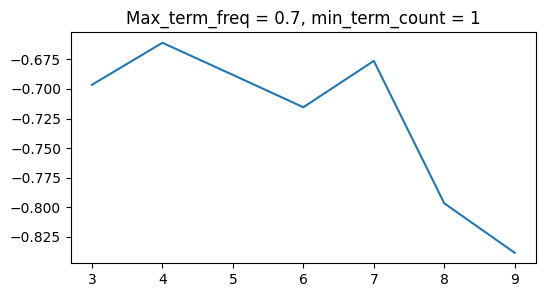

In [15]:
plt.figure(figsize = (6,3))
plt.plot(dict_coherence_score_topic_count.keys(),
        dict_coherence_score_topic_count.values())
plt.title('Max_term_freq = {}, min_term_count = {}'.format(max_term_freq, min_term_count))

# Visualize model

## pyLDAvis

In [16]:
pyLDAvis.enable_notebook()

In [17]:
Lda3, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 3, Word2id)

In [18]:
vis3 = pyLDAvis.gensim_models.prepare(Lda3, Corpus, D, sort_topics = False)
vis3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.070262  0.094111       1        1  29.234824
1     -0.078679 -0.090631       2        1  36.052170
2      0.148941 -0.003480       3        1  34.713007, topic_info=          Term         Freq        Total Category  logprob  loglift
410      blood  1638.000000  1638.000000  Default  30.0000  30.0000
670      level   818.000000   818.000000  Default  29.0000  29.0000
411   pressure   754.000000   754.000000  Default  28.0000  28.0000
162  infection   624.000000   624.000000  Default  27.0000  27.0000
409       high   536.000000   536.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
132    include   287.574973   618.513645   Topic3  -4.9969   0.2922
147       know   304.875411  1082.791689   Topic3  -4.9385  -0.2093
57        stop   281.749426   724.997359   Topic3  -5.0174   0.1129
194       feel   272.250786   577.432738   Topic3  -5.0517   0.3062
123       will   279.189503   817.288650   Topic3  -5.0265  -0.0160

[280 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
93        1  0.222351      about
93        2  0.729054      about
93        3  0.049174      about
8         1  0.017226       acne
8         2  0.981878       acne
...     ...       ...        ...
238       1  0.971347  worsening
238       2  0.008521  worsening
238       3  0.017041  worsening
867       1  0.014502  yellowing
867       3  0.986168  yellowing

[577 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [19]:
Lda4, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 4, Word2id)

In [20]:
print('This model has coherence score = {}'.format(Coherence_score))

This model has coherence score = -0.5575674702638906


In [21]:
vis4 = pyLDAvis.gensim_models.prepare(Lda4, Corpus, D, sort_topics = False)
vis4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.034847  0.012302       1        1  23.869233
1      0.172824  0.036197       2        1  23.182345
2     -0.032808 -0.151012       3        1  24.585198
3     -0.105170  0.102514       4        1  28.363224, topic_info=          Term         Freq        Total Category  logprob  loglift
410      blood  1620.000000  1620.000000  Default  30.0000  30.0000
411   pressure   748.000000   748.000000  Default  29.0000  29.0000
162  infection   641.000000   641.000000  Default  28.0000  28.0000
148        all   507.000000   507.000000  Default  27.0000  27.0000
409       high   531.000000   531.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
112       food   244.010727   736.240998   Topic4  -4.9592   0.1557
147       know   233.852373  1083.285797   Topic4  -5.0017  -0.2730
132    include   212.820421   622.690143   Topic4  -5.0960   0.1865
146    disease   210.192301   623.851758   Topic4  -5.1084   0.1722
131       most   216.381205   855.424801   Topic4  -5.0794  -0.1145

[360 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
93        1  0.236420      about
93        2  0.034388      about
93        3  0.713560      about
93        4  0.017194      about
8         1  0.008814       acne
...     ...       ...        ...
198       2  0.042873     worsen
198       3  0.746712     worsen
198       4  0.010718     worsen
1521      3  0.961096  wrestling
990       1  0.968953       year

[758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [43]:
# Lda5, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 5, Word2id)

In [44]:
# print('This model has coherence score = {}'.format(Coherence_score))

In [45]:
# vis5 = pyLDAvis.gensim_models.prepare(Lda5, Corpus, D, sort_topics = False)
# vis5

# Save model
- best coherence score (and visually best separations) with LDA model with 4 topics
- to show on streamlit
    - good instr: https://medium.com/@lelwonger/incorporating-functions-with-html-output-in-streamlit-pyldavis-lime-25b13717d913
    

In [35]:
Lda4.save('../models/lda4.model')

In [36]:
# for visualization
pyLDAvis.save_html(vis3, '../models/vis4.html')

In [3]:
tempfile = datapath('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4.model')

In [38]:
Lda4.save(tempfile)

In [81]:
# save Corpus as well
corpora.MmCorpus.serialize('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4_corpus', Corpus)

In [98]:
# corpora.Dictionary.save('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4_dictionary')

# Check how to use model

## from model, get topic-term matrix

In [4]:
lda_fromload = models.LdaModel.load(tempfile)

In [5]:
lda_fromload

In [6]:
# topics-term matrix
#https://stackoverflow.com/questions/47424335/access-term-topic-matrix-generated-by-gensim-lda

df_topic_term_matrix = pd.DataFrame(lda_fromload.get_topics(), 
                                     columns = lda_fromload.id2word.values(), 
                                     index=[f'topic {i}' for i in range(lda_fromload.num_topics)])

In [7]:
df_topic_term_matrix

,2,3d,3l,6l,ab,abd,abdomen,abdominal,abel,abhayrab,...,xl,xp,xps,xr,year,yellow,yellowing,yellowness,yourself,zone
topic 0,0.000009,0.000008,0.000105,0.000095,0.000319,0.000060,0.000047,0.000544,0.000078,0.000009,...,0.000009,0.000119,0.000008,0.000009,0.000571,0.000243,0.000039,0.000009,0.000300,0.000075
topic 1,0.000009,0.000009,0.000010,0.000010,0.000009,0.000091,0.000171,0.000014,0.000010,0.000009,...,0.000280,0.000009,0.000009,0.000110,0.000009,0.000040,0.000014,0.000011,0.000052,0.000009
topic 2,0.000072,0.000009,0.000009,0.000019,0.000158,0.000008,0.000344,0.001265,0.000008,0.000072,...,0.000009,0.000094,0.000008,0.000008,0.000010,0.000008,0.000578,0.000009,0.000054,0.000008
topic 3,0.000007,0.000149,0.000007,0.000008,0.000008,0.000007,0.000027,0.001174,0.000060,0.000007,...,0.000007,0.000008,0.000092,0.000007,0.000008,0.000008,0.001414,0.000176,0.000907,0.000007


In [8]:
pd.set_option('display.max_columns', None)
df_topic_term_matrix.loc['topic 0'].sort_values(ascending = False)[:80]

take       0.019935
tablet     0.012640
dose       0.012095
blood      0.010926
can        0.009837
             ...   
which      0.003089
prevent    0.003084
full       0.003029
stop       0.003009
dos        0.002988
Name: topic 0, Length: 80, dtype: float32

## from model, get topic probabilities for each entry

In [12]:
df.iloc[1]['Introduction']

"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day.\xa0 The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms.\xa0 It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may 

In [13]:
df_topic_term_matrix.loc['topic 0'].sort_values(ascending = False)[:50]

take          0.019935
tablet        0.012640
dose          0.012095
blood         0.010926
can           0.009837
that          0.008899
know          0.008562
without       0.008335
most          0.008129
symptom       0.007955
advised       0.007541
food          0.007540
how           0.007353
get           0.007164
on            0.006608
some          0.006553
will          0.006511
cause         0.006432
these         0.006373
so            0.006065
treat         0.006025
liver         0.005623
better        0.005568
medication    0.005462
way           0.005458
feel          0.005413
day           0.005408
help          0.005366
work          0.005339
include       0.005299
level         0.005253
need          0.005176
inform        0.005113
body          0.005106
even          0.005095
make          0.005084
heart         0.005036
change        0.004922
while         0.004873
same          0.004462
an            0.004455
dizziness     0.004448
however       0.004413
nausea     

In [14]:
df.head(2)

,Introduction
0,Acnesol Gel is an antibiotic that fights bacte...
1,Ambrodil Syrup is used for treating various re...


In [66]:
len(Corpus)

1000

In [15]:
lda_corpus = corpora.MmCorpus('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4_corpus')

In [16]:
len(lda_corpus)

1000

In [20]:
def get_medication_name(text):
    
    first_sentence = text.partition('.')[0]
    name = ' '.join(re.findall(r'\b[A-Z][a-z]+|\b[A-Z]\b', first_sentence))
    
    return name

In [21]:
df['medication_name'] = df['Introduction'].apply(lambda x: get_medication_name(x))

In [22]:
df.head(2)

,Introduction,medication_name
0,Acnesol Gel is an antibiotic that fights bacte...,Acnesol Gel
1,Ambrodil Syrup is used for treating various re...,Ambrodil Syrup


In [23]:
list_topic_estimation = []
for i in range(len(lda_corpus)):   
    topic_estimation = lda_fromload.get_document_topics(lda_corpus[i])
    list_topic_estimation.append(topic_estimation)

In [24]:
list_topic_estimation[:2]

[[(1, 0.99324274)], [(0, 0.5467407), (2, 0.44747737)]]

In [25]:
topic_count = 4
for i in range(topic_count):
    column_name = 'topic' + str(i)
    df[column_name] = 0.0

In [26]:
df['topic_estimation'] = list_topic_estimation

In [27]:
for i in range(len(df)):
# for i in range(2):
#     print('i: ', i)
    for j in df.iloc[i].loc['topic_estimation']:
#         print('j: ', j)
        for k in range(topic_count):
#             print('k: ', k)
            if k == j[0]:
                estimation = j[1]
#                 print('estimation: ', estimation)
                column_name = 'topic' + str(k)
#                 print('column_name: ', column_name)
                df.at[i, column_name] = estimation

In [28]:
df.head()

,Introduction,medication_name,topic0,topic1,topic2,topic3,topic_estimation
0,Acnesol Gel is an antibiotic that fights bacte...,Acnesol Gel,0.000000,0.993243,0.000000,0.000000,"[(1, 0.99324274)]"
1,Ambrodil Syrup is used for treating various re...,Ambrodil Syrup,0.546741,0.000000,0.447477,0.000000,"[(0, 0.5467407), (2, 0.44747737)]"
2,Augmentin 625 Duo Tablet is a penicillin-type ...,Augmentin Duo Tablet,0.000000,0.000000,0.993552,0.000000,"[(2, 0.9935516)]"
3,Azithral 500 Tablet is an antibiotic used to t...,Azithral Tablet,0.000000,0.992813,0.000000,0.000000,"[(1, 0.9928131)]"
4,Alkasol Oral Solution is a medicine used in th...,Alkasol Oral Solution,0.000000,0.000000,0.455564,0.538127,"[(2, 0.455564), (3, 0.5381267)]"


In [33]:
str(df.iloc[0].values)

"['Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do 

In [113]:
import re
# s = 'Everyday HOLDS the poSSibility Of A Miracle. This is great!'
s = df.iloc[0]['Introduction']
text = s.partition('.')[0]
new_s = ' '.join(re.findall(r'\b[A-Z][a-z]+|\b[A-Z]\b', text))

In [114]:
text

'Acnesol Gel is an antibiotic that fights bacteria'

In [115]:
new_s

'Acnesol Gel'